In [1]:
import sys
import os
import math
import matplotlib.pyplot as plt
import numpy as np

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath('.'),os.pardir))
sys.path.append(PROJECT_ROOT)

from electronTransportCode.ProjectUtils import tuple3d, ERE
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron

%matplotlib widget

In [2]:
SEED = 4
rng = np.random.default_rng(SEED)
def sampleInitIsotropic() -> tuple3d:
    vec = np.array((0.0, 0.0, 0.0), dtype=float)
    cost = rng.uniform(low=-1, high=1)
    phi = rng.uniform(low=0.0, high=2*np.pi)
    cosphi = math.cos(phi)
    sinphi = math.sin(phi)
    sint = math.sqrt(1.0 - cost**2)
    vec[0] = sint*cosphi
    vec[1] = sint*sinphi
    vec[2] = cost
    return vec

def getDirection(cost: float, phi: float, vec3d: tuple3d, NEW_ABS_DIR: bool = False) -> tuple3d:
    """Scatter a particle across polar angle (theta) and azimuthatl scattering angle phi

    Args:
        cost (float): Cosine of polar scattering angle
        phi (float): Azimuthal scattering angle in radians
        vec3d (tuple3d): Direction of travel
        NEW_ABS_DIR (bool, optional): If True, cost and phi are interpreted in speherical coordinates. Defaults to False.

    Returns:
        tuple3d: Direction of travel after scattering cost and phi with respect to vec3d
    """
    sint = np.sqrt(1 - cost**2)
    cosphi = np.cos(phi)
    sinphi = np.sin(phi)

    new_vec3d = np.array((0.0, 0.0, 0.0), dtype=float)

    # Rotation matrices (See penelope documentation eq. 1.131)
    if np.isclose(np.abs(vec3d[2]), 1.0, rtol=1e-14) or NEW_ABS_DIR:  # indeterminate case
        sign = np.sign(vec3d[2])
        new_vec3d[0] = sign*sint*cosphi
        new_vec3d[1] = sign*sint*sinphi
        new_vec3d[2] = sign*cost
    else:
        tempVar = np.sqrt(1-np.power(vec3d[2], 2))
        new_vec3d[0] = vec3d[0]*cost + sint*(vec3d[0]*vec3d[2]*cosphi - vec3d[1]*sinphi)/tempVar
        new_vec3d[1] = vec3d[1]*cost + sint*(vec3d[1]*vec3d[2]*cosphi + vec3d[0]*sinphi)/tempVar
        new_vec3d[2] = vec3d[2]*cost - tempVar*sint*cosphi

    # normalized for security
    new_vec3d = new_vec3d/np.linalg.norm(new_vec3d)
    return new_vec3d


In [3]:
particle = SimplifiedEGSnrcElectron(rng)

# Simulate scattering of particle in water at 4.0 MeV

N = 100000
E_MeV = 4.0
E = 4.0/ERE

# Accumulate in new vec in array. Plot, and compute average and variance. This should be 0 and 1/3!
vecs = np.empty(shape=(N, 3), dtype=float)
for i in range(N):
    vec = sampleInitIsotropic()
    phi = rng.uniform(low=0.0, high=2*np.pi)
    mu = rng.uniform(low=0, high=0.8)*rng.choice([1.0, -1.0])
    vecs[i, :] = getDirection(mu, phi, vec)

print(vecs.mean(axis=0))
print(vecs.var(axis=0))

[-0.00144348 -0.00234602 -0.0014033 ]
[0.33316186 0.33254101 0.33428757]


(-1.0, 1.0)

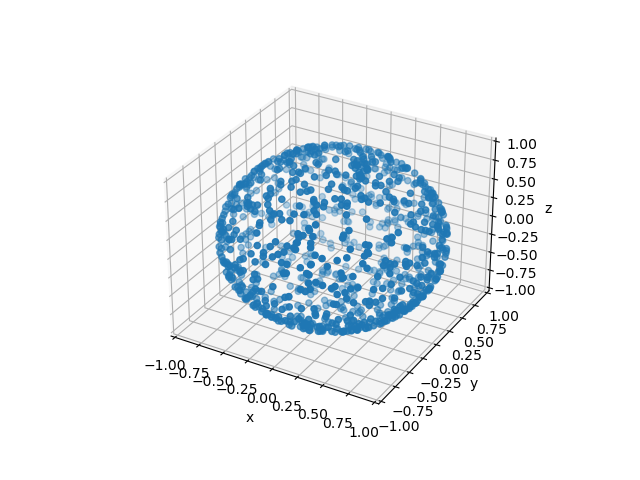

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(vecs[0:1000, 0], vecs[0:1000, 1], vecs[0:1000, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])